# ***Salary Predictions Based on Job Descriptions***

The purpose of this project is to make accurate salary preditctions that are based on existing known salaries so the company is able to recruit and retain top talent. This model will help the company for offering competetive pay to existing and future employees while also keeping payroll expenses in check. 

Data transformation and machine learning will be used to create a model that will predict a salary when given years of experience, job type, college degree, college major, industry, and miles from a metropolis.

The data for this model is relatively simplified as it has very few missing areas. The raw data consists of a dataset with the features listed above and their corresponding salaries. Twenty percent of this dataset was split into a test dataset with corresponding salaries so accuracy and error of the model can be determined.

__The features in this data set are described as below:__

__Years Experience__: How many years of experience <br>
__Job Type__: The position held (CEO, CFO, CTO, Vice President, Manager, Janitor, and senior or junior position)<br>
__College Degree__: Doctoral, Masters, Bachelors, High School, or None<br>
__College Major__: Biology, Business, Chemistry, Computer Science, Engineering, Literature, Math, Physics, or None<br>
__Industry__: Auto, Education, Finance, Health, Oil, Service, or Web<br>
__Miles From Metropolis__: How many miles away from a major city<br>

In [1]:
#import required libraries
import pandas as pd
import sklearn as sk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor

## Data Preparation


#### Define relevant functions needed in the span of the project

In [2]:
#function to load the data into a Pandas Dataframe
def load_f(file):
    return pd.read_csv(file)

#clean the data - remove duplicates and salaries that are $0
def clean_d(original_df):
    clean_d = original_df.drop_duplicates(subset='jobId')
    clean_d = original_df[original_df.salary>0]
    return clean_d
    
#scatter plots 
def scatter_data(df, col):
    plt.figure(figsize = (12,8))
    plt.scatter(df[col], df['salary'] )
    plt.ylabel('salary')
    plt.xlabel(col)

#regression plots
def reg_data(df, col):
    plt.figure(figsize=(12,8))
    sns.regplot(x=df[col], y = df['salary'], data = df, line_kws = {'color' : 'red'})    
    plt.ylim(0,)
    
#residual plots 
def res_data(df,col):
    plt.figure(figsize=(12,8))
    sns.residplot(x=df[col], y = df['salary'], data = df)
    plt.show()

#distribution plots 
def dis_data(Rfunction, Bfunction, Rname, Bname, title):
    plt.figure(figsize=(10,6))
    ax1 = sns.distplot(Rfunction, hist = False, color = 'r', label = Rname)
    ax1 = sns.distplot(Bfunction, hist = False, color = 'b', label = Bname)
    plt.title(title)
    plt.show()
    plt.close()
    
    

In [3]:

#load data
print("Loading data..")
train_feat_df = load_f('train_features.csv')
train_target_df = load_f('train_salaries.csv')

#define the variables
cat_vars = ['companyId', 'jobType', 'degree', 'major', 'industry']
num_vars = ['yearsExperience', 'milesFromMetropolis']
tar = 'salary'

#verify data is laoded 
train_feat_df.head()


Loading data..


,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [4]:
#verify data is loaded - 
train_target_df.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


#### See lengths and dtypes of the loaded data frames


In [5]:
train_feat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309461 entries, 0 to 309460
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   jobId                309461 non-null  object
 1   companyId            309461 non-null  object
 2   jobType              309461 non-null  object
 3   degree               309461 non-null  object
 4   major                309461 non-null  object
 5   industry             309461 non-null  object
 6   yearsExperience      309461 non-null  int64 
 7   milesFromMetropolis  309461 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 18.9+ MB


In [6]:
train_target_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   jobId   1000000 non-null  object
 1   salary  1000000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 15.3+ MB


#### Check the shape of the dataframes

In [7]:
#shape of the data
print(train_feat_df.shape)
print(train_target_df.shape)


(309461, 8)
(1000000, 2)


  __The data in the train_target_df has only the salary information, i.e the target variable along with jobId that corresponds with the jobId in the train_target_df. We will merge the two in a single dataframe.__

In [8]:
#merge training data with features and training data with salary - store in train_df
train_df = pd.merge(train_feat_df,train_target_df, on = 'jobId')

In [9]:
#verify features on merged data
train_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [10]:
#verify shape of the merged data-
print(train_df.shape)

(309461, 9)


__The dataframes merged correctly as we can see the shape and features are correct.__ 

__Check for missing values -__


In [11]:
#store the sum of missing values in each column - 
missing_val = train_df.isnull().sum()
missing_val

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
salary                 0
dtype: int64

__Note that there are no missing values.__

__Next we go ahead with cleaning the data.__


In [12]:
#store the the salaries in the training data which are less than or equal to 0
zero_sal = train_df['salary']<=0
inval = train_df[zero_sal]
inval


,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0


__There are 5 salaries that are of value $0 and the corresponding details i.e, jobType, degree, major, etc do not justify that these 
positions are of volunteer level. Hence, these salaries will be considered invalid and we can remove these entries and yet 
remain with a lot of data for the analysis and predictions.__


In [13]:
#clean the data i.e, remove duplicates and remove the salaries that are invalid or not useful for predictions like salary<=0
#calling the function
clean_train_df = clean_d(train_df)


In [14]:
print(clean_train_df.shape)

(309460, 9)


In [15]:
#Reset the index values after dropping the invalid values 
clean_train_df.reset_index(drop = True)
clean_train_df.tail()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
309456,JOB1362684717143,COMP46,CTO,NONE,NONE,EDUCATION,7,93,114
309457,JOB1362684717144,COMP25,SENIOR,NONE,NONE,HEALTH,24,98,97
309458,JOB1362684717145,COMP26,CFO,HIGH_SCHOOL,NONE,FINANCE,19,67,140
309459,JOB1362684717146,COMP26,JANITOR,NONE,NONE,HEALTH,7,70,40
309460,JOB1362684717147,COMP47,SENIOR,DOCTORAL,ENGINEERING,AUTO,21,36,182


__Next, data types will be checked to make sure they are appropriate corresponding to the columns.__

In [16]:
print(clean_train_df.dtypes)

jobId                  object
companyId              object
jobType                object
degree                 object
major                  object
industry               object
yearsExperience         int64
milesFromMetropolis     int64
salary                  int64
dtype: object


## Exploratory Data Analysis

__Descriptive statistics of quantitative data__

In [17]:
clean_train_df.describe()


,yearsExperience,milesFromMetropolis,salary
count,309460.000000,309460.000000,309460.000000
mean,11.980947,49.475438,116.062279
std,7.208792,28.876309,38.771956
min,0.000000,0.000000,17.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,49.000000,114.000000
75%,18.000000,74.000000,141.000000
max,24.000000,99.000000,294.000000


__The minimum, maximum and the range of these numbers all seem appropriate for their corresponding columns. The mean and stand
ard deviation of do not indicate anything wrong.__ 


In [18]:
#count of unique values in categorical data
for cat in cat_vars:
    if cat != 'jobId' and cat != 'companyId':
       print(clean_train_df[cat].value_counts())
    

JANITOR           38961
VICE_PRESIDENT    38926
SENIOR            38857
CTO               38812
CEO               38754
MANAGER           38519
JUNIOR            38475
CFO               38156
Name: jobType, dtype: int64
NONE           73825
HIGH_SCHOOL    73250
DOCTORAL       54251
MASTERS        54145
BACHELORS      53989
Name: degree, dtype: int64
NONE           165187
BUSINESS        18135
LITERATURE      18103
ENGINEERING     18098
PHYSICS         18090
BIOLOGY         18039
CHEMISTRY       18015
COMPSCI         17981
MATH            17812
Name: major, dtype: int64
FINANCE      44370
HEALTH       44271
OIL          44253
SERVICE      44219
WEB          44126
AUTO         44114
EDUCATION    44107
Name: industry, dtype: int64


In [19]:
# unique values in clean_train_df data -
clean_train_df.nunique()

jobId                  309460
companyId                  63
jobType                     8
degree                      5
major                       9
industry                    7
yearsExperience            25
milesFromMetropolis       100
salary                    272
dtype: int64

__There is a unique jobId for each row in the data and so it will be dropped to reduce the noise in the prediction.__ 

__Are salaries normally distributed?__

In [20]:
#compute the kurtosis and skewness of salary
print('Salary Skewness:', clean_train_df['salary'].skew())
print('Salary Kurtosis:', clean_train_df['salary'].kurt())
print('\n')
if -0.5 <= clean_train_df['salary'].skew() <= 0.5:
    print('Salary distribution is approximately symmetric')
elif -0.5 >  clean_train_df['salary'] > 0.5:
    print('Salary distribution is skewed')
    


Salary Skewness: 0.34562957820456003
Salary Kurtosis: -0.030504498935802538


Salary distribution is approximately symmetric


### Visualize target variable (Salary)


In [21]:
#We use IQR to identify potential outliers 

stats = clean_train_df['salary'].describe()
IQR = stats['75%'] - stats['25%']
upper_bound = stats['75%'] + 1.5 * IQR
lower_bound = stats['25%'] - 1.5 * IQR
print('The upper and lower bounds for suspected outliers are {} and {}.'.format(upper_bound, lower_bound))

The upper and lower bounds for suspected outliers are 220.5 and 8.5.


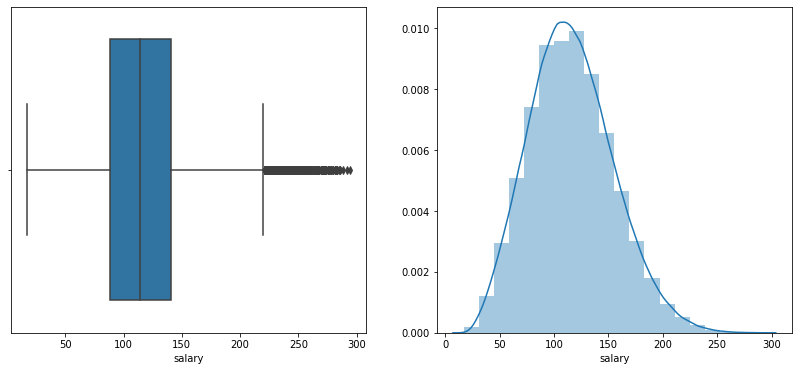

In [22]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
sns.boxplot(clean_train_df['salary'])
plt.subplot(1,2,2)
sns.distplot(clean_train_df['salary'], bins = 20)
plt.show()

In [23]:
# Examine the outliers below the lower bound- 
clean_train_df[clean_train_df['salary'] < 8.5]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary


__Note - We had spotted five salaries with $0 entry and we dropped those earlier. Looks like we sorted our outliers below the 
lower bound. <br>
Next, let us examine the outliers above__

In [24]:
#Examine potential outliers above the upper bound - 
clean_train_df.loc[clean_train_df['salary'] > 220.5, 'jobType'].value_counts()

CEO               1011
CTO                490
CFO                452
VICE_PRESIDENT     180
MANAGER             68
SENIOR              22
JUNIOR               8
Name: jobType, dtype: int64

In [25]:
#Examine the outliers for a particular type(JUNIOR) of column, jobType - 
clean_train_df[(clean_train_df['salary'] > 220.5) & (clean_train_df['jobType'] == 'JUNIOR')]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
1222,JOB1362684408909,COMP40,JUNIOR,MASTERS,COMPSCI,OIL,24,5,225
27710,JOB1362684435397,COMP21,JUNIOR,DOCTORAL,ENGINEERING,OIL,24,3,246
31355,JOB1362684439042,COMP45,JUNIOR,DOCTORAL,COMPSCI,FINANCE,24,0,225
100042,JOB1362684507729,COMP17,JUNIOR,DOCTORAL,BUSINESS,FINANCE,23,8,248
160333,JOB1362684568020,COMP18,JUNIOR,DOCTORAL,BUSINESS,FINANCE,22,3,223
189582,JOB1362684597269,COMP32,JUNIOR,DOCTORAL,BUSINESS,OIL,24,11,221
214606,JOB1362684622293,COMP47,JUNIOR,MASTERS,BUSINESS,FINANCE,22,4,222
303778,JOB1362684711465,COMP51,JUNIOR,MASTERS,ENGINEERING,WEB,24,2,226


__The high salary potential outliers seem to be either C-level executives or the Juniors  are in industries such as Oil, Finance etc. who are known to have higher salaries. Hence, we do not drop them as they seem appropriate.__

### Visualize numerical data with salary

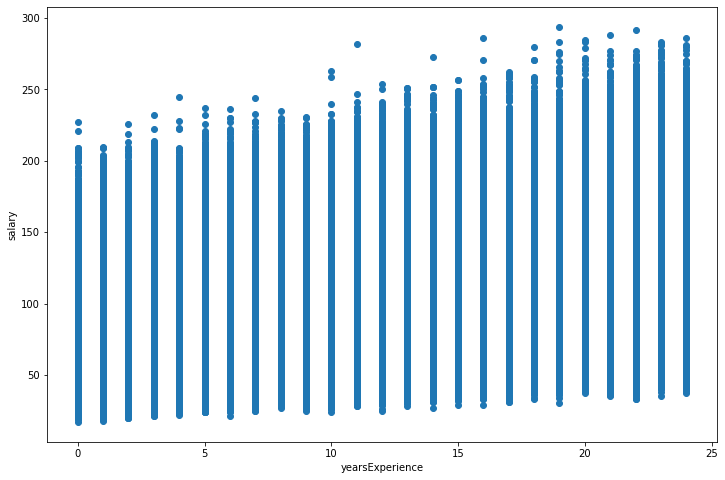

In [26]:
##Calling the function
scatter_data(clean_train_df, 'yearsExperience')

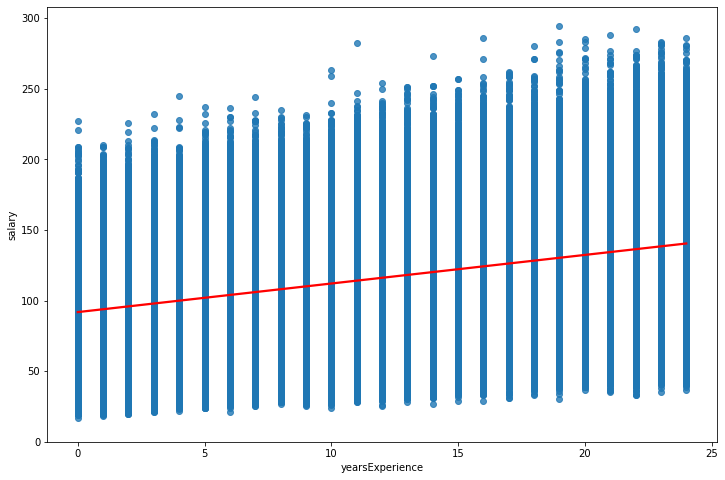

In [27]:
#Fit a regression line to years experience to visualize it as a predictor of salary - 
#Calling the function
reg_data(clean_train_df, 'yearsExperience')

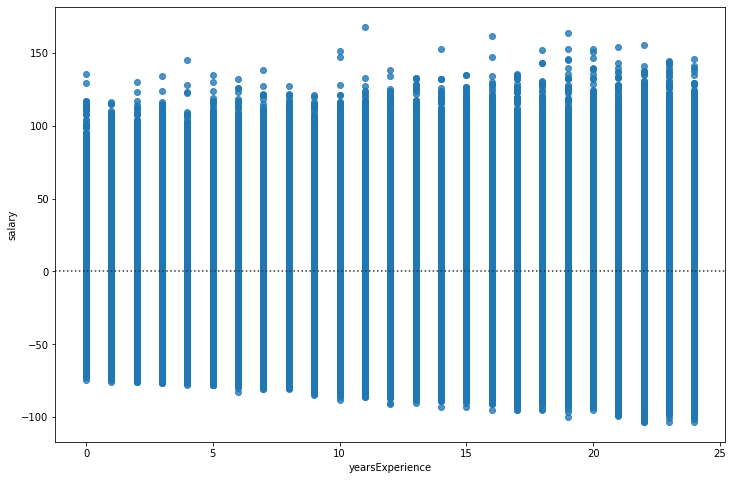

In [28]:
#Variance of yearsExperience-
#Calling the function
res_data(clean_train_df, 'yearsExperience')

__Variance in salary seems to slightly increase with increasing yearsExperience.__

__Data seems to be spread away from the regression line. We can also see a weak positive relationship between yearsExperience 
and salary.__ 

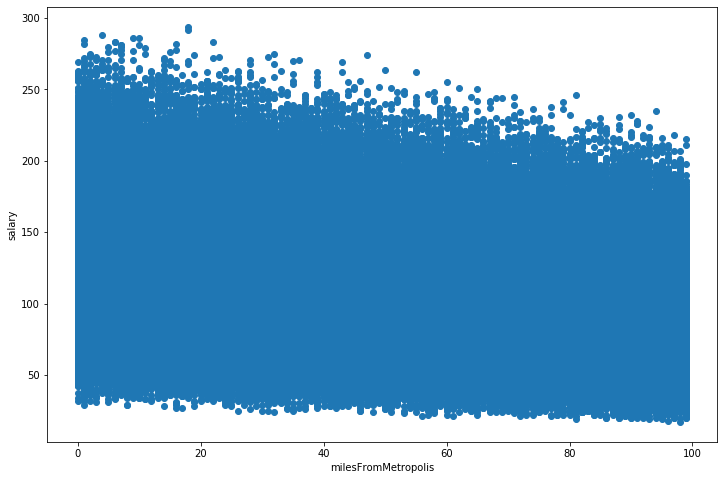

In [29]:
scatter_data(clean_train_df, 'milesFromMetropolis')

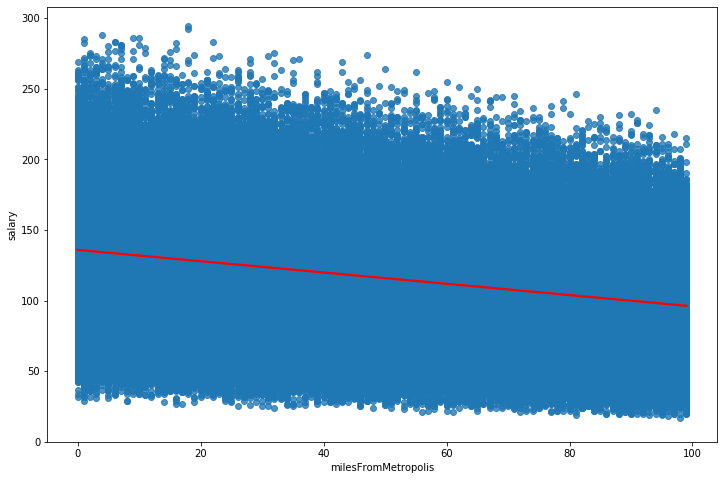

In [30]:
#Fit a regression line to miles from metropolis to visualize it as a predictor of salary -
reg_data(clean_train_df, 'milesFromMetropolis')

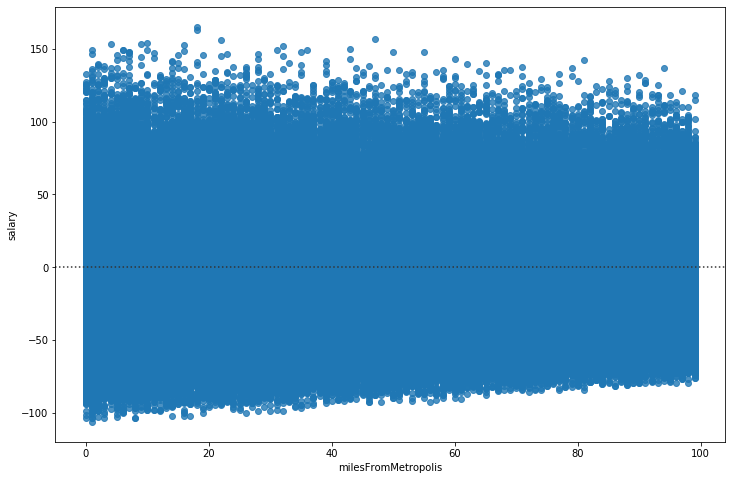

In [31]:
#Variance of milesfrom Metropolis
res_data(clean_train_df, 'milesFromMetropolis')

__Variance in salary seems to slightly decrease with increasing milesFromMetropolis.__ 

__Data is widely spread from the regression line and we can see a weak negative relationship between miles from metropolis and 
salary.__ 

### Relationships with categorical features-

In [32]:
# drop jobId and companyId 
clean_train_df.drop(['jobId'], axis = 1, inplace = True)
clean_train_df.drop(['companyId'], axis = 1, inplace = True)

In [33]:
clean_train_df.head()

,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,CFO,MASTERS,MATH,HEALTH,10,83,130
1,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


__Next we visualize each categorical feature to see which features could be good predictors of salary. We use the violin plot here to see the shape of the distribution curve along with mean and interquartile ranges.__ 

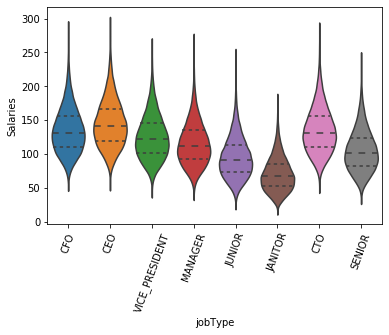

In [34]:
sns.violinplot(x = clean_train_df.jobType, y = clean_train_df['salary'], data = clean_train_df, scale = 'count', inner = 'quartile')
plt.xticks(rotation = 70)
plt.ylabel('Salaries')
plt.show()

__We can see a clear positive correlation between jobType and salary. 
The highest salaries are CEO, followed by CTO and followed by CFO. The lowest salary is for the jobtype Janitor. Distributions appear normal.__

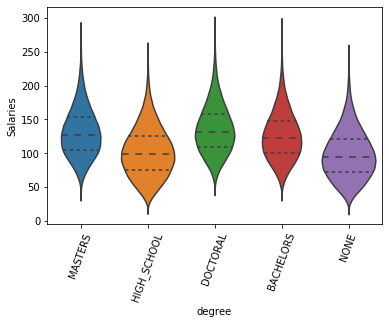

In [35]:
sns.violinplot(x = clean_train_df.degree, y = clean_train_df['salary'], data = clean_train_df, scale = 'count', inner = 'quartile')
plt.xticks(rotation = 70)
plt.ylabel('Salaries')
plt.show()

__We can see that having a college degree corresponds to having higher salaries than high school or no degree. Salary seems to increase with the advance in degrees.__ 

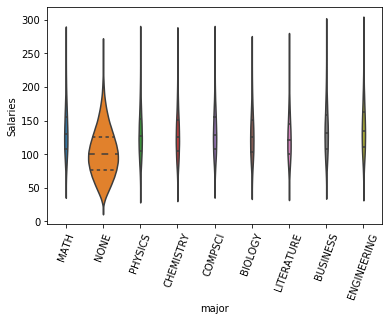

In [36]:
sns.violinplot(x = clean_train_df.major, y = clean_train_df['salary'], data = clean_train_df, scale = 'count', inner = 'quartile')
plt.xticks(rotation = 70)
plt.ylabel('Salaries')
plt.show()

__We can see that people with majors such as engineering, business and math have higher salaries. 
Also, having a major definitely leads to having higher salaries than having no major. Having no major corresponds to people following in the group of no degree and those with only highschool. 
Distributions appear normal.__ 

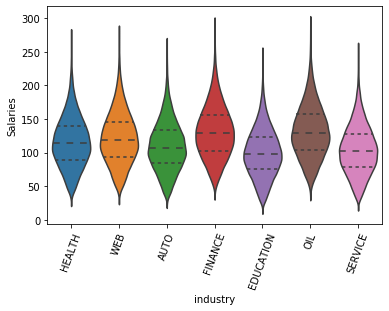

In [37]:
sns.violinplot(x = clean_train_df.industry, y = clean_train_df['salary'], data = clean_train_df, scale = 'count', inner = 'quartile')
plt.xticks(rotation = 70)
plt.ylabel('Salaries')
plt.show()

__Industries such as Oil pay the highest, followed by finance and web. Education industry seems to pay the lowest.__ 

__Now dummy variables will be assigned to categorical data ("one-hot encoding") so it can be used in the prediction models.__ 

In [38]:
## One-hot encode categorical data in clean_train_df dataset
clean_train_df = pd.get_dummies(clean_train_df)

In [39]:
clean_train_df.head()

,yearsExperience,milesFromMetropolis,salary,jobType_CEO,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,...,major_MATH,major_NONE,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
0,10,83,130,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,3,73,101,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,10,38,137,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,8,17,142,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,8,16,163,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


### Correlation between all the features

__Now that numerical values are assigned to all features we can see the correlation between all of them.__

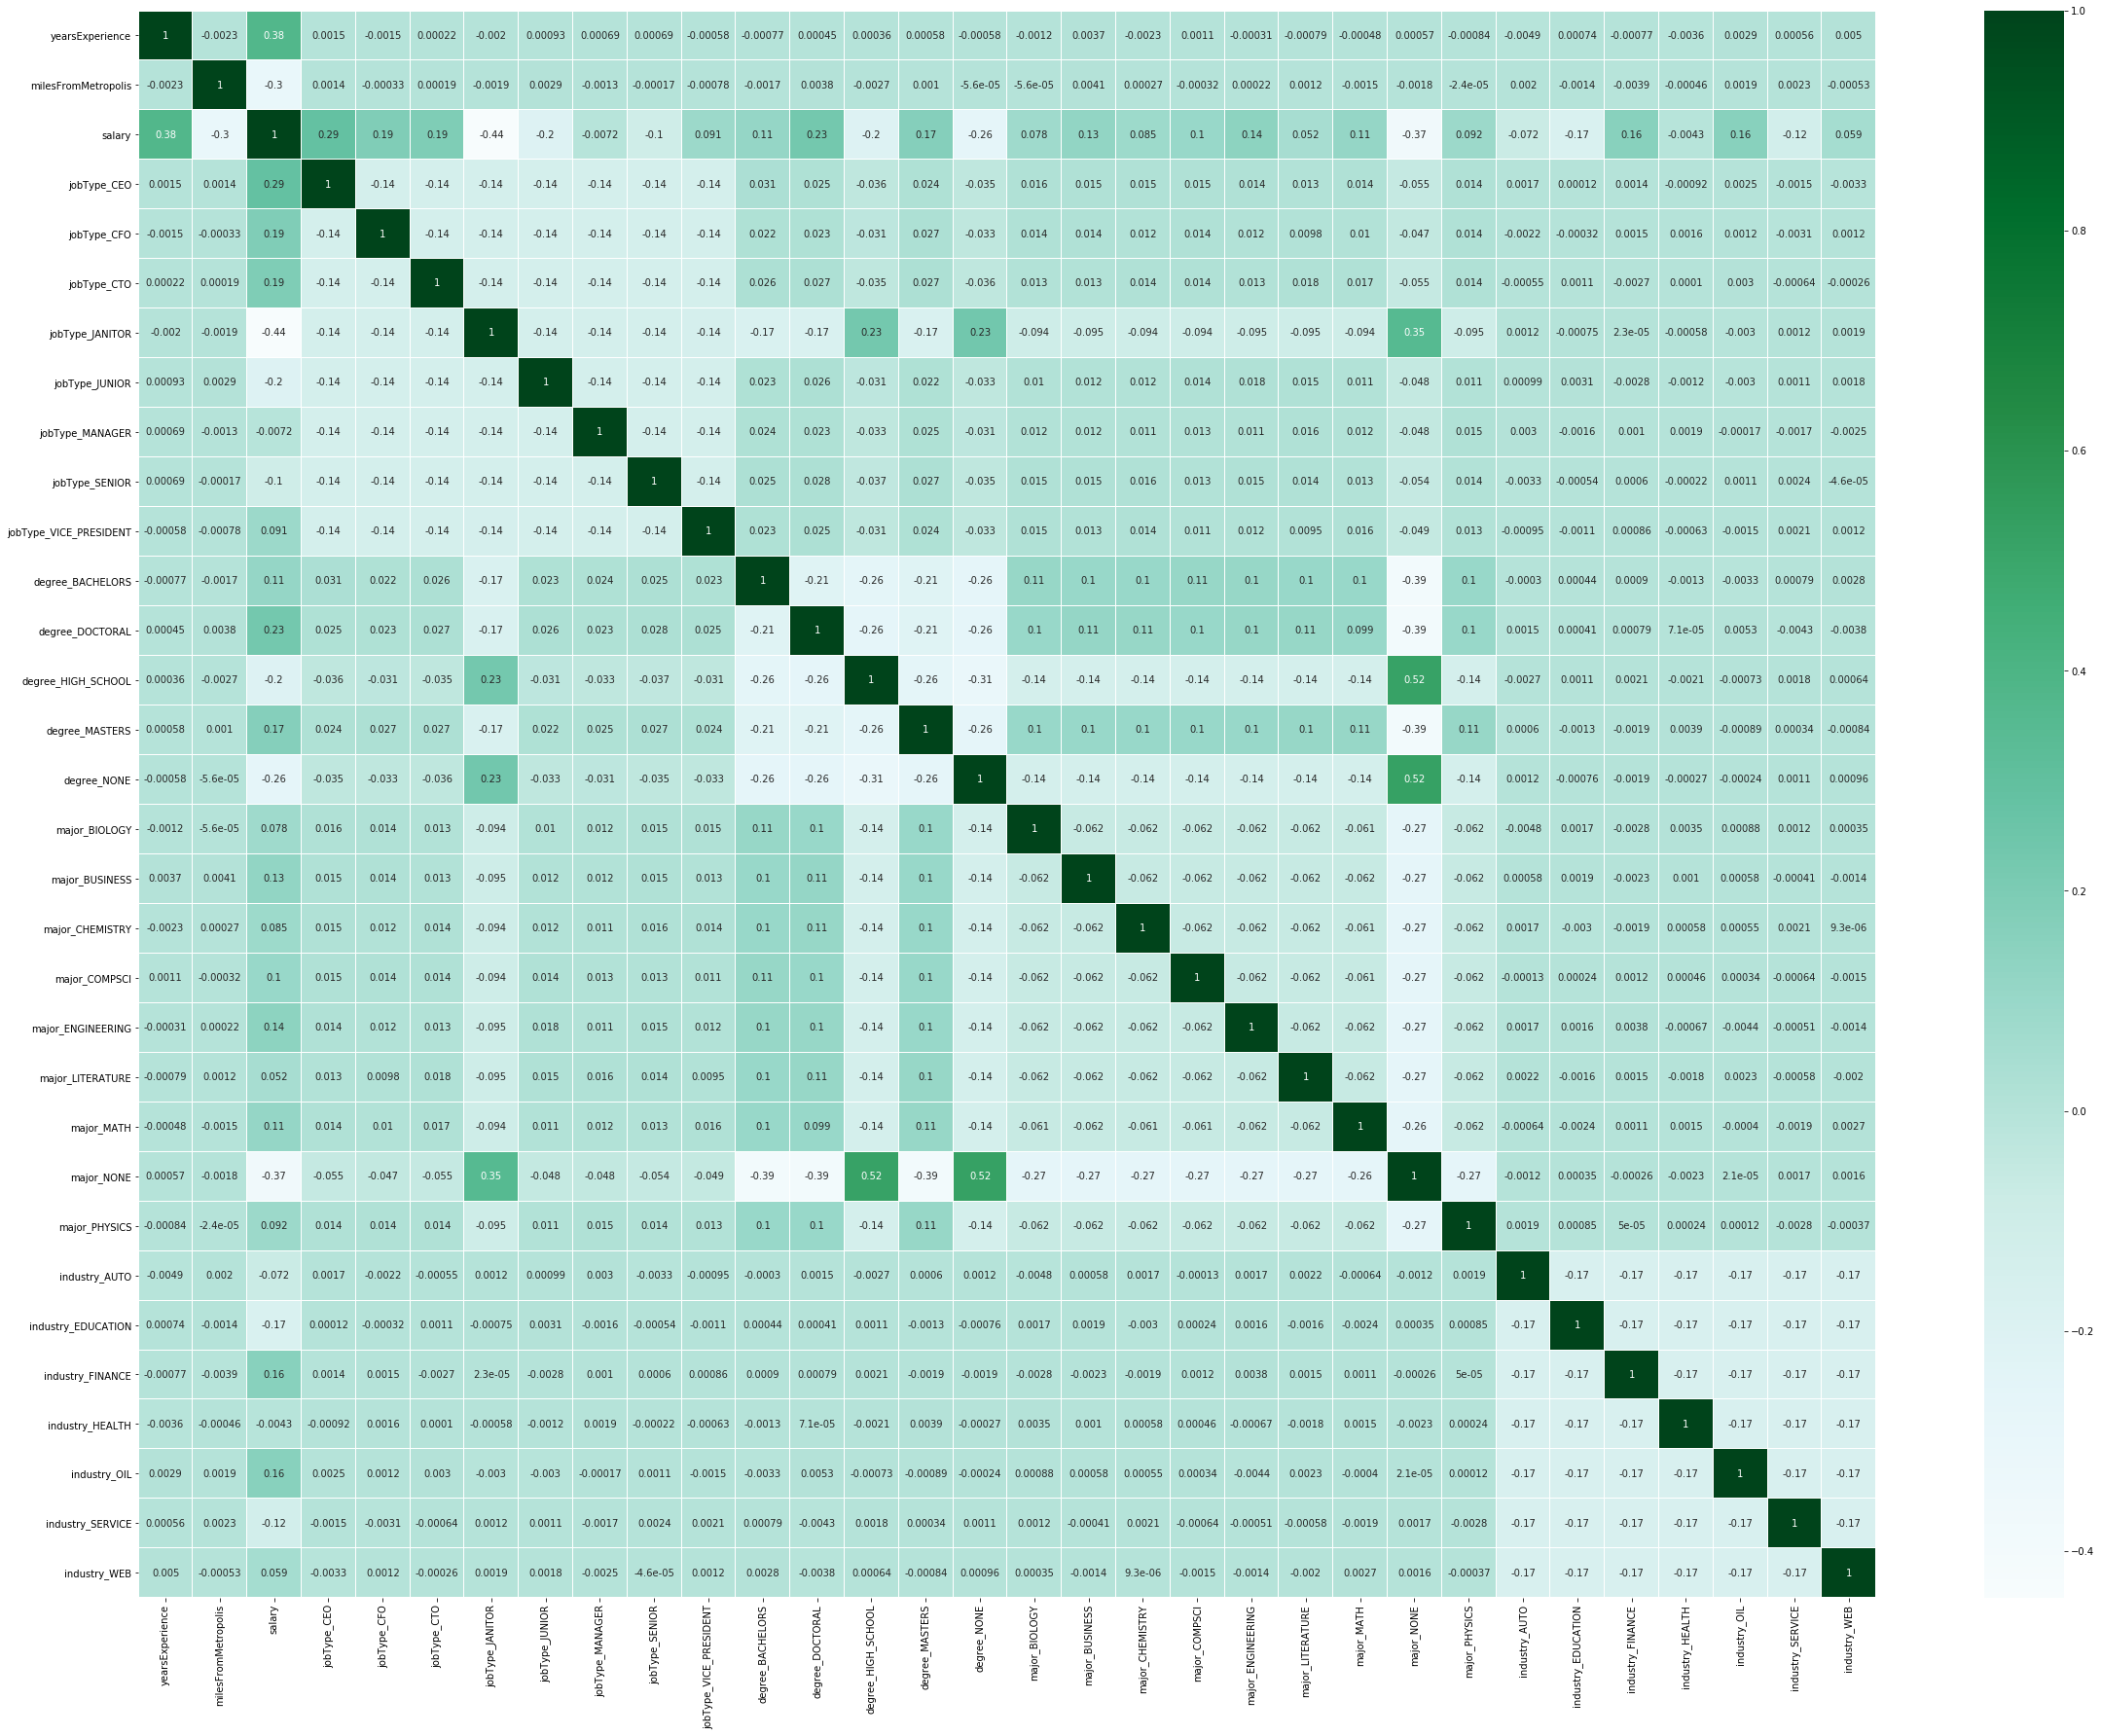

In [40]:
# Plot heatmap of all data with correlation coefficients visible
clean_train_df_corr = clean_train_df.corr()
plt.subplots(figsize=(40,30))
sns.heatmap(clean_train_df_corr, cmap = 'BuGn', linewidth =.005, annot = True)

__yearsExperience has the highest correlation with salary. jobType also seems to be correlated with salary.__ 

__To create a basic training model, two variables will be assigned for the model to use. Twenty percent of the training data will be split into testing data that we can use to test the model with data for which the salaries are already known.__ 

In [41]:
#Split the data and assign 'salary' to 'sal_df' and the rest of the features to 'feat_df'. 
feat_df = clean_train_df[clean_train_df.loc[ :, clean_train_df.columns != 'salary'].columns]
sal_df = clean_train_df['salary']
feat_train, feat_test, sal_train, sal_test = train_test_split(feat_df, sal_df, test_size = 0.2, random_state = 1)

In [42]:
feat_df

,yearsExperience,milesFromMetropolis,jobType_CEO,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,jobType_VICE_PRESIDENT,...,major_MATH,major_NONE,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
0,10,83,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,3,73,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,10,38,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
3,8,17,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,8,16,0,0,0,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309456,7,93,0,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
309457,24,98,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0
309458,19,67,0,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
309459,7,70,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0


In [44]:
feat_df.to_csv('31 Training columns.csv')

In [45]:
sal_df

0         130
1         101
2         137
3         142
4         163
         ... 
309456    114
309457     97
309458    140
309459     40
309460    182
Name: salary, Length: 309460, dtype: int64

In [46]:
#View inputs and outputs of training model
feat_train.head()

,yearsExperience,milesFromMetropolis,jobType_CEO,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,jobType_VICE_PRESIDENT,...,major_MATH,major_NONE,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
125169,7,75,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
86955,6,45,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
141979,14,64,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
174970,9,50,0,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
264782,19,60,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [47]:
sal_train.head()

125169    106
86955     119
141979     99
174970    136
264782    106
Name: salary, dtype: int64

__We will use linear regression here as salary is a continious variable. With all the data, we see that this is a case of Supervised Regression learning. We will establish the baseline model by appling Linear Regression to feat_train, sal_train.__ 

In [48]:
#Create Linear Regression Object and fit the model
lm = LinearRegression()
lm.fit(feat_train,sal_train)
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

__Next, we will view the coefficients of our model -__ 

In [49]:
#View coeff of Linear Regression object 
print(lm.intercept_)
print(lm.coef_)

53035093496.76106
[ 2.01650639e+00 -3.98342267e-01  1.36867911e+11  1.36867911e+11
  1.36867911e+11  1.36867911e+11  1.36867911e+11  1.36867911e+11
  1.36867911e+11  1.36867911e+11 -5.61378531e+10 -5.61378531e+10
 -5.61378531e+10 -5.61378531e+10 -5.61378531e+10 -6.66857079e+09
 -6.66857078e+09 -6.66857079e+09 -6.66857079e+09 -6.66857078e+09
 -6.66857079e+09 -6.66857078e+09 -6.66857079e+09 -6.66857079e+09
 -1.27096581e+11 -1.27096581e+11 -1.27096581e+11 -1.27096581e+11
 -1.27096581e+11 -1.27096581e+11 -1.27096581e+11]


__Now that the baseline model is created, it can predict the salaries. The variable yhat is used to store the predictions using the training data.__ 

In [50]:
#predict salary using training data
yhat = lm.predict(feat_train)

#View first five predictions -
print ('First five predictions:' , yhat[0:5])

First five predictions: [110.89552307 105.95429993  85.66069031 128.16203308  84.63621521]


In [51]:
yhat_pr = lm.predict([[10,83,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0]])

In [52]:
yhat_pr[:5]

array([128.20218658])

__Mean squared error (MSE) will be evaluated now along with accuracy and r-squared to evaluate the baseline model's performance and to determine if the subsequent models improve over the established baseline model.__ 

In [ ]:
#print MSE - 
print ('Mean Squared Error of our prediction model', mean_squared_error(sal_train, yhat))

#### K-Fold Cross Validation

Cross-validation is a procedure used to avoid overfitting and estimate the skill of the model on new data.
The value for k is chosen such that each train/test group of data samples is large enough to be statistically representative of the broader dataset.

In [ ]:
# accurace of the baseline model using 5-cross validation method -
score = cross_val_score(lm, feat_train, sal_train, cv = 5)
print ('5-Cross Validation accuracy', (np.mean(score)), (np.std(score)))

In [ ]:
#distribution plot 
#Calling the function
Title = 'Distribution PLot of Actual Values vs Predicted Values'
dis_data(sal_train, yhat, 'Actual Values(train data)', 'Predicted Values(train data)', Title)

__We can see that the actual values and predicted values are not that different. The mean of the predicted values seems higher and the range seems lower.__

__Next, we do the same for the 20% test data to see if the outcome is similar.__ 

In [ ]:
#store test set predictions in yhat_test 
yhat_test = lm.predict(feat_test)

#view first five predictions - 
print ('First five predictions(test data)', yhat_test[0:5])

In [ ]:
#MSE of test data - 
print ('Mean Squared Error of test data ', mean_squared_error(sal_test, yhat_test))

__We can see that Mean squared error of the training data and test data is very similar.__

In [ ]:
#accuracy of test data using 5-cross validation method - 
score = cross_val_score(lm, feat_test, sal_test, cv = 5)
print ('5-cross validation accuracy(test data)', (np.mean(score)), (np.std(score)))

In [ ]:
#Distribution plot 
Title = 'Distribution Plot of Predicted values of test data vs Actual values of test data'
dis_data(sal_test, yhat_test, 'Actual Values(test)', 'Predicted Values(test)', title = Title)

__Distribution, accuracy and MSE are not very different when comparing the training data and test data.__ 

__We now try to see if we can reduce the MSE to less than 360.__ 

__Three models that may improve results over the baseline model are -__ 
1. Apply Polynomial Transformation
2. Use Ridge Regression
3. Use Random Forest

   __The shape and features of the training data and testing data will be checked before applying models on them.__

In [ ]:
#shape and features -

print ('Number of training samples-', feat_train.shape, '\n with the features-', feat_train.columns)
print ('Number of testing samples-', feat_test.shape, '\n with the features-', feat_test.columns)
print ('Number of training salaries-', sal_train.shape)
print ('Number of testing salaries-', sal_test.shape)

__We will first apply Polynomial Features to already built Linear regression model and see if MSE reduces.__

In [ ]:
#Fit and transform the variables with 2nd order polynomial
pr = PolynomialFeatures(2)
feat_train_pr = pr.fit_transform(feat_train)
feat_test_pr = pr.fit_transform(feat_test)
pr

In [ ]:
#Create a new model using Polynomial Transformation 
poly = LinearRegression()
poly.fit(feat_train_pr, sal_train)

In [ ]:
feat_test.columns

In [ ]:
feat_train_pr[0].shape

In [ ]:
#make predictions and view first five predictions on train data - 
yhat_pr = poly.predict(feat_train_pr)
print ('First five predictions(train data)-', yhat_pr[0:5])

In [ ]:
#Compare first five predicted values vs actual values - 
print ('Predicted Values(train)-', yhat_pr[0:5])
print ('Actual Values(train)-', sal_train[0:5].values)

In [ ]:
#make predictions and view first five predictions on test data - 
yhat_prtest = poly.predict(feat_test_pr)
print ('First five predictions(test data)-', yhat_prtest[0:5])

In [ ]:
#Compare predicted values of test data and actual values of test data - 
print ('Predicted values(test)-', yhat_prtest[0:5])
print ('Actual values(test)-', sal_test[0:5].values)

In [ ]:
#print R-squared values of training and testing data - 
print ('R-squared of training data-', poly.score(feat_train_pr, sal_train))
print ('R-squared of testing data-', poly.score(feat_test_pr, sal_test))

__Minor improvement over base model (0.02)__


In [ ]:
#MSE of training and testing data - 
print ('MSE of training data-', mean_squared_error(sal_train, yhat_pr))
print ('MSE of testing data-', mean_squared_error(sal_test, yhat_prtest))

In [ ]:
#View distribution plot of actual vs fitted of training data - 
dis_data(sal_test, yhat_pr, 'Actual Values(train)', 'Predicted Values(train)', title = 'Distribution PLot of actual values of training data vs predicted values of training data')

In [ ]:
#view distribution plot of actual vs fitted of testing data - 
dis_data(sal_test, yhat_prtest, 'Actual Values(test)', 'Predicted Values(test)', title = 'Distribution PLot of actual values of testing data vs predicted values of testing data')


__Next let us try using Random Forest and Fit a Randorm Forest with random_state = 1 for consistency__

In [ ]:
#create a random forest object - 
RF = RandomForestRegressor(n_estimators = 150, n_jobs = 2, max_features = 30)
RF

In [ ]:
#fit a Random Forest model on training data - 
RF.fit(feat_train, sal_train)

In [ ]:
#make predictions on testing data and print the first five - 
yhat_RF_test = RF.predict(feat_test)
print ('First five predictions-', yhat_RF_test[0:5])

In [ ]:
yhat_pr = RF.predict([[10,83,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0]])

In [ ]:
yhat_pr

In [ ]:
feat_test.shape

In [ ]:
#R-squared and MSE of test data - 
print ('R-squared of test data-', RF.score(feat_test, sal_test))
print ('MSE of test data-', mean_squared_error(sal_test, yhat_RF_test))

In [53]:
import pickle

In [54]:
filename = 'salary_pickle.pkl'
pickle.dump(lm, open(filename, 'wb'))

__Linear regression with second order polynomial transformation gave best predictions with MSE of 354 and accuracy of 76%. 
This meets the goal of reducing MSE to below 360.__ 

__Random Forest resulted in worse MSE of approximately 441 and the accuracy of 70%.__ 

## Summary

__Applying second order polynomial transformation to the features gave the most accurate with the least error when using a Linear Regression Model. The result was a mean squared error of 354 with the accuracy of 76%.__ 

__This model can be used as a guide when determining salaries since it results in resonable predictions when given information on years of experience, miles from Metropolis, job type, industry, college degree and major.__ 
